In [83]:
print(1)

1


In [5]:
import numpy as np
from math import isnan
import threading as trd
import math
import random as rnd
import copy
    

#def estimate_gaussian(data):
 #   return np.mean(data),np.cov(data)
    
    
def info_gain(data,cov,data_l,cov_l,data_r,cov_r):
    
    a=np.linalg.det(cov)
    if(isnan(a)==True):
        a=0.000000000000000000001
    a=np.log(abs(a))
    
    
    b=np.linalg.det(cov_l)
    if np.isnan(b)==True:
        b=0.000000000000000000001
    #print(data_l.shape[1])
    b=(data_l.shape[0]/data.shape[0]) * np.log(abs(b))
    
    
    c=np.linalg.det(cov_r)
    if np.isnan(c)==True:
        c=0.000000000000000000001
    c=(data_r.shape[0]/data.shape[0]) * np.log(abs(c))
    
    
 #   print('b: '+str(b) +' shape: '+str(data_l.shape))
  #  print('c: '+str(c) +' shape: '+str(data_r.shape))
   # print('infogain: '+str(a-b-c))
    return a-b-c
    
def split_data_axis(data,split,direction):
#    print('hi')
    left_data=np.array([[0,0]])
    right_data=np.array([[0,0]])
    for d in range(data.shape[0]):
        if data[d][direction]<=split:
            left_data=np.append(left_data,np.reshape(data[d],(1,data[d].shape[0])),axis=0)
        else:
            right_data=np.append(right_data,np.reshape(data[d],(1,data[d].shape[0])),axis=0)
            
   # print(left_data)
    left_data=np.delete(left_data,0,axis=0)
    right_data=np.delete(right_data,0,axis=0)
    return(left_data,right_data)
    
def split_data_lin(data,start,direction):
    left_data=np.array([[0,0]])
    right_data=np.array([[0,0]])
    i=0
    for d in range(data.shape[0]):
        #print(np.cross(direction-start,start-d))
        #(b−a)×(c−a)
        #if i<=5:
         #   print(d,start,(start+direction)-start,d-start)
          #  i+=1
        if np.cross((start+direction)-start,data[d]-start)<0:
            left_data=np.append(left_data,np.reshape(data[d],(1,data[d].shape[0])),axis=0)
        else:
            right_data=np.append(right_data,np.reshape(data[d],(1,data[d].shape[0])),axis=0)
            
   # print(left_data)
    left_data=np.delete(left_data,0,axis=0)
    right_data=np.delete(right_data,0,axis=0)
    return(left_data,right_data)

class RandomDensityTree:

    def __init__(self,max_depth=10,num_splits=50,min_infogain=2,rand=True,splittype='axis'):
       # print(data)
        self.rand=rand
        self.splittype=splittype
        self.max_depth = max_depth
        #self.root=data
        tree=[]
        for i in range(30):
            tree.append(0)
        self.tree=tree
        self.min_infogain=min_infogain
        self.num_splits=num_splits
        
    def fit(self,data,axis=0):
        if(axis==1):
            data=np.transpose(data)
        self.size=data.shape[0]
        self.root=data
        self.mean = np.mean(data,axis=0)
        self.cov=np.cov(np.transpose(data))
        self.rootnode=Node(data,self.cov,[],self.tree,num_splits=self.num_splits,min_infogain=self.min_infogain,max_depth=self.max_depth,pointer=0,rand=self.rand,splittype=self.splittype)
        self.tree[0]=self.rootnode

    def predict(self,points):
        new=[]
        for p in points:
            new.append(self.rootnode.predict(p))
        new=np.array(new)
        return new
    
    def max_prob():
        leafs=self.leaf_nodes()
        probs=[]
        for l in leafs:
            probs.append(np.det(cov))*math.sqrt(2*math.pi)
        return max(probs)

    def get_means(self):
        means=[]
        self.rootnode.get_means(means)
        return means
    
    def get_split_info(self):
        histories=[]
        self.rootnode.get_split_info(means)
        return histories
   # def maxinfo(self):
    #    np.cov(np.transpose(left_data))
    def leaf_nodes(self):
        leafs=[]
        self.rootnode.leaf_nodes(leafs)
        return np.array(leafs)
    
class Node:
    
    def __init__(self,data,cov,history,tree,num_splits,min_infogain,max_depth,pointer,rand=True,splittype='axis'):
     #   print(data.shape)
        #self.min_infgain=min_infgain
        self.maxdepth=max_depth
        self.min_infogain=min_infogain
        self.pointer=pointer
        self.size=data.shape[0]
        self.tree=tree
        self.num_splits=num_splits
    #    tree[pointer]={''}
        self.split=float('nan')
        self.split_dim=float('nan')
        self.history=copy.deepcopy(history)
        self.splittype=splittype
        self.root=data
        self.mean=np.mean(data,axis=0)
        self.cov=cov
        self.isLeaf=False
        self.left_child=float('nan')
        self.right_child=float('nan')
        if(max_depth==0 or data.shape[0]==1):
            self.isLeaf=True
           
        else:
            
            rnd_splits=[]
            if(rand==True):
                for dim in range(int(num_splits)):
                    direction=rnd.choice([0,1])

                    rnd_split=rnd.uniform(min(data[:,direction]),max(data[:,direction]))
                

                    rnd_splits.append({'split':rnd_split,'direction':direction})

            else:
                rnd_splits=np.concatenate([np.linspace(min(data[:,0]),max(data[:,0])),np.linspace(min(data[:,1]),max(data[:,1]))],axis=0)
           
        
            if(self.splittype=='linear'):
                rnd_splits=[]
                for n in range(num_splits):
                    start=np.array([rnd.uniform(min(data[:,0]),max(data[:,0])),rnd.uniform(min(data[:,1]),max(data[:,1]))])
                    dir1=rnd.uniform(0,1)
                    direction=np.array([dir1,1-dir1])
                    direction[0]= direction[0]*rnd.choice([-1,1])
                    direction[1]= direction[1]*rnd.choice([-1,1])
                    rnd_splits.append({'split': start,'direction': direction})
                    
            
            left_datas=[]
            info_gains=np.zeros(num_splits)
            right_datas=[]

            covs_left=[]
            covs_right=[]

            for s in range(num_splits):#or the number of random splits
                
                
                if (self.splittype=='linear'):
                    left_data,right_data=split_data_lin(data,rnd_splits[s]['split'],rnd_splits[s]['direction'])
                else:
                    left_data,right_data=split_data_axis(data,rnd_splits[s]['split'],rnd_splits[s]['direction'])
                if(left_data.shape[0]>2 and right_data.shape[0]>2):
          #          print('split ' +str(rnd_splits[s]['split'])+'  direction: '+str(rnd_splits[s]['direction']))
                   # left_data=[] #data left of the split
                   # right_data=[] #data right of the split
                    #for a in data:
                     #   if a <= splits[d]:
                      #      if(max_depth=left_data.append(a)
                       # else:
                        #    right_data.append(a)
                  #  right_data

                    right_datas.append(right_data)
                    left_datas.append(left_data)

                    cov_l=np.cov(np.transpose(left_data))
                    cov_r=np.cov(np.transpose(right_data))

                    covs_left.append(cov_l)
                    covs_right.append(cov_r)
                 #   print(left_data)
                    info_gains[s]=(info_gain(data,self.cov,left_data,cov_l,right_data,cov_r)) #entropies of left and right data)
                else:
                    right_datas.append(float('nan'))
                    left_datas.append(float('nan'))
                    covs_left.append(float('nan'))
                    covs_right.append(float('nan'))
                    #information gain if this split is used
            if len(info_gains)==0:
                self.isLeaf=True
                   
            else:

                best=np.argmax(info_gains)
                print('best infogain: '+str(info_gains[best]))
            #    print(min_infogain)
                if info_gains[best] >= min_infogain:
                    
                    self.split=rnd_splits[best]['split']   #best split
                    self.split_dim=rnd_splits[best]['direction'] 
                    self.history.append(rnd_splits[best])
                    if(2*pointer+2>=len(tree)):
                        for i in range((2*pointer+2)-len(tree)+1):
                            tree.append(0)
                   # print(left_datas[best].shape)
                    #print(right_datas[best].shape)
                    print(self.history)
                    #print((left_datas[best],covs_left[best],history,tree,self.num_splits,self.min_infogain,self.maxdepth-1,2*pointer+1))
                    self.history[len(self.history)-1]['child']='left'
                    print(('history',self.history))
                    leftnode=Node(left_datas[best],covs_left[best],self.history,tree,self.num_splits,self.min_infogain,self.maxdepth-1,2*pointer+1,rand=rand,splittype=self.splittype)
                    tree[2*pointer+1]=leftnode
                    self.left_child=leftnode
            
                   # print(len(right_datas[best],covs_right[best],history,self.num_splits,self.min_infogain,s2))
                    
                    self.history[len(self.history)-1]['child']='right'
                    rightnode=Node(right_datas[best],covs_right[best],self.history,tree,self.num_splits,self.min_infogain,self.maxdepth-1,2*pointer+2,rand=rand,splittype=self.splittype)
                    tree[2*pointer+2]=rightnode
                    self.right_child=rightnode
                    
                else:
         
                    self.isLeaf=True
       # print((self.isLeaf,self.left_child))
    def predict(self,point):
        if self.isLeaf==True:
            return self.pointer
        else:
            if(self.splittype=='axis'):
                if point[self.split_dim]<=self.split:
                    return self.left_child.predict(point)
                else:
                    return self.right_child.predict(point)
            else:
                #(b−a)×(c−a)
                 if np.cross((self.split+self.split_dim)-self.split,point-self.split)<0:
                    return self.left_child.predict(point)
                 else:
                    return self.right_child.predict(point)
                
    '''         
     def get_split_info(self,histories):
        if(self.isLeaf==True):
            return self.history
            print('whoa')
        else:
            return [{'split':self.split,'split_dim':self.split_dim,},{'left_child':self.left_child.get_results()},{'right_child':self.right_child.get_results()}]
    '''
    def get_split_info(self,histories):
        if(self.isLeaf==True):
            histories.append(self.history)
        else:
            self.left_child.get_histories(histories)
            self.right_child.get_histories(histories)

    def get_means(self,means):
        if(self.isLeaf==True):
            means.append(self.mean)
        else:
            self.left_child.get_means(means)
            self.right_child.get_means(means)
            
    def maxprob():
        return 1
    
    def leaf_nodes(self,leafs):
      #  if self.left_child.isLeaf == True:
       #     leafs.append(self.left_child.pointer)
        if(self.isLeaf==True):
            leafs.append(self.pointer)
        else:
            self.left_child.leaf_nodes(leafs)
      #  if self.right_child.isLeaf == True:
       #     leafs.append(self.right_child)
        #else:
            self.right_child.leaf_nodes(leafs)
        
    def isnan(self):
        return False
    
def partition_function(tree, x):
    # generate a lot of samples in the bounds of the data and the size of the bounded shape
    samples, b_size = generate_monte_carlo_sample(x)
    # add gaussian probability dimension for those samples
    g_probs_samples = np.random.random(len(samples))*tree.max_prob
    b_size = b_size*tree.max_prob
    # predict the target leb af nodes for all samples
    leaf_node_ids = tree.predict(samples)
    # compute the distribution integral over each leaf node
    g_ints = np.zeros((len(tree.leaf_nodes),))
    for ln_id in range(len(tree.leaf_nodes)):
        leaf_node = tree.leaf_nodes[ln_id]
        mean_vec = leaf_node.mean
        cov_mat = leaf_node.cov
        mnd = stats.multivariate_normal(mean_vec, cov_mat)
        sample_id_mask = leaf_node_ids==ln_id
        g_probs = mnd(samples[sample_id_mask])
        g_cnt = np.sum(g_probs_samples<=g_probs)
        g_ints[ln_id] = g_cnt/len(samples)*b_size
    


def generate_monte_carlo_sample(X, num_samples=1000000):
    """
    Generate more sample points
    """
    samples = np.random.rand(num_samples,len(X[0]))
    d_mins = np.min(X,axis=0)
    d_maxs = np.max(X,axis=0)
    samples = np.add(np.multiply(samples,d_maxs-d_mins),d_mins)
    b_size = np.prod(d_maxs-d_mins)
    return samples, b_size    
'''
class RandomDensityForest:
    def _init(self,max_length=10,num_trees=10):
        self.max_length=max_length
        self.num_trees=num_trees
        
    def train_and_stuff(data):
        #lauch DensityTrees
        #train on data
        #return results
        #use partition function
        #combine them into final result
    
    I= entropy - sum
theta= max(I)    
'''

'\nclass RandomDensityForest:\n    def _init(self,max_length=10,num_trees=10):\n        self.max_length=max_length\n        self.num_trees=num_trees\n        \n    def train_and_stuff(data):\n        #lauch DensityTrees\n        #train on data\n        #return results\n        #use partition function\n        #combine them into final result\n    \n    I= entropy - sum\ntheta= max(I)    \n'

In [33]:
import numpy as np
print(DensityTree.get_means())

[array([ 2.05841503,  2.06321624]), array([ 5.03663098,  0.87954265]), array([ 0.96257205,  4.60034381]), array([ 0.65848779,  5.38033305]), array([ 1.93028167,  5.32164957]), array([ 5.02506548,  4.98309083])]


In [34]:
print(data.shape)
print(np.transpose(data))

(100, 2)
[[ 1.03754758  1.59824847  2.1094747   1.72474419  2.60194843  1.66887751
   2.30300722  2.13949212  2.23919738  3.02216989  1.41400904  1.52764539
   2.25428669  1.57872018  2.24928277  1.98478355  1.61697816  2.2378951
   2.13131992  2.42739006  1.57987549  2.6174872   2.22615305  1.9327085
   2.24214422  1.96694538  1.68309953  1.82213385  1.74698534  2.61205976
   4.38325036  5.46426579  4.77346388  5.10730759  4.31582577  5.51430176
   4.68832277  5.23180012  4.98181384  5.19559707  3.98617335  5.3916823
   5.56200171  5.15216081  4.54216899  5.28040938  4.93992198  5.53074282
   5.27417027  5.07325563  5.25024567  5.04646415  4.68361286  5.45586867
   4.77003518  5.44930709  5.0263038   4.11747432  5.67781836  4.88619818
   4.85483572  5.44570126  4.25431411  5.10341994  4.5558685   5.90372469
   4.87667182  4.53749919  4.90154359  4.75546725  5.47857912  5.72373977
   4.91428181  5.12806875  4.9654399   3.51425534  4.86135439  4.97855688
   4.42076619  4.6130944   4.907

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
#

data = np.zeros([100,2])
for i in range(30):
    data[i]=np.random.normal([2,2],0.5)
   # data[i][0]=np.random.normal(2,0.5)[0]
    #data[i][1]=np.random.normal(2)[1]
for i in range(30):
    data[30+i]=np.random.normal([5,5],0.5)
    #data[30+i][1]=np.random.normal(5,0.5) 
for i in range(30):
    data[60+i]=np.random.normal([5,1],0.5)
   
for i in range(10):
    data[90+i]=np.random.normal([1,5],0.5)

DensityTree=RandomDensityTree(max_depth=2,min_infogain=0.2,num_splits=50)
DensityTree.fit(data)
DensityTree2=RandomDensityTree(max_depth=2,splittype='linear',min_infogain=0.2,num_splits=400)
DensityTree2.fit(data)
print(DensityTree2.tree)
print(DensityTree2.leaf_nodes())

best infogain: 2.71124874216
[{'direction': 1, 'split': 4.2227352513236527}]
('history', [{'direction': 1, 'child': 'left', 'split': 4.2227352513236527}])
best infogain: 2.1037195416
[{'direction': 1, 'child': 'left', 'split': 4.2227352513236527}, {'direction': 0, 'split': 3.4590920327261983}]
('history', [{'direction': 1, 'child': 'left', 'split': 4.2227352513236527}, {'direction': 0, 'child': 'left', 'split': 3.4590920327261983}])
best infogain: 2.74774257414
[{'direction': 1, 'child': 'right', 'split': 4.2227352513236527}, {'direction': 0, 'split': 2.7196009235332852}]
('history', [{'direction': 1, 'child': 'right', 'split': 4.2227352513236527}, {'direction': 0, 'child': 'left', 'split': 2.7196009235332852}])
best infogain: 2.71124874216
[{'direction': array([ 0.96593011,  0.03406989]), 'split': array([ 4.35045252,  3.60656122])}]
('history', [{'direction': array([ 0.96593011,  0.03406989]), 'child': 'left', 'split': array([ 4.35045252,  3.60656122])}])
best infogain: 2.1389957466
[

In [28]:

DensityTree2=RandomDensityTree(max_depth=4, min_infogain=0.5)
DensityTree2.fit(data)
DensityTree2.predict([[2,3],[4,5]])

split 1.15791903589  direction: 0
b: -0.191063872787 shape: (7, 2)
c: 2.0313123849 shape: (93, 2)
infogain: 0.515682689316
split 1.57376464125  direction: 0
b: -0.301408061345 shape: (15, 2)
c: 1.65424919917 shape: (85, 2)
infogain: 1.0030900636
split 4.6193453947  direction: 0
b: 0.672873923825 shape: (51, 2)
c: -0.141175771521 shape: (49, 2)
infogain: 1.82423304912
split 3.56161425818  direction: 1
b: -0.263184250412 shape: (60, 2)
c: -0.226027947043 shape: (40, 2)
infogain: 2.84514339888
split 3.69239213956  direction: 1
b: -0.263184250412 shape: (60, 2)
c: -0.226027947043 shape: (40, 2)
infogain: 2.84514339888
split 3.18622632318  direction: 0
b: -0.319511880631 shape: (39, 2)
c: 0.227782638181 shape: (61, 2)
infogain: 2.44766044387
split 0.315955939055  direction: 1
b: -0.169785114189 shape: (3, 2)
c: 2.25093774661 shape: (97, 2)
infogain: 0.274778569002
split 4.68264789544  direction: 0
b: 0.768836235573 shape: (53, 2)
c: -0.161094831836 shape: (47, 2)
infogain: 1.74818979769
spl

array([18, 27])

In [59]:
print(partition_function(tree,100))

TypeError: 'int' object is not subscriptable

[3 4 5 6]
3
4
5
6
('tree covariance: ', array([[ 0.25646299, -0.04140129],
       [-0.04140129,  0.23408442]]))
('tree covariance 2: ', array([[ 0.25646299, -0.04140129],
       [-0.04140129,  0.23408442]]))
('tree covariance: ', array([[ 0.45307121,  0.01298852],
       [ 0.01298852,  0.32791351]]))
('tree covariance 2: ', array([[ 0.45307121,  0.01298852],
       [ 0.01298852,  0.32791351]]))
('tree covariance: ', array([[ 0.16861775,  0.03487184],
       [ 0.03487184,  0.05834685]]))
('tree covariance 2: ', array([[ 0.16861775,  0.03487184],
       [ 0.03487184,  0.05834685]]))
('tree covariance: ', array([[ 0.28926083, -0.00829391],
       [-0.00829391,  0.18724902]]))
('tree covariance 2: ', array([[ 0.28926083, -0.00829391],
       [-0.00829391,  0.18724902]]))


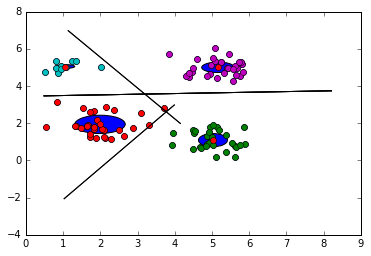

In [21]:
from matplotlib.patches import Ellipse

def plotsplits(h,s,hor=[0,6],vert=[0,6]):
   
        plotsplits(h,s+1,hor,vert) 

fig = plt.figure(0)
ax = fig.add_subplot(111)

nodes=DensityTree2.leaf_nodes()
print(nodes)
for d in nodes:
    print(d)
tree=DensityTree2.tree
plt.plot(data[:,0],data[:,1], "o")
for d in nodes:
    plt.plot(tree[d].root[:,0],tree[d].root[:,1], "o")
    vert=[0,6]
    hor=[0,6]
    for h in tree[d].history:
        
       
        ax.plot([(h['split']+h['direction']*4)[0],(h['split']+h['direction']*-4)[0]],[(h['split']+h['direction']*4)[1],(h['split']+h['direction']*-4)[1]],color='k')
    #        if(h['child']=='left'):
     #           hor=[hor[0],h['split']]
      #      else:
      #          hor=[h['split'],hor[1]]
      #  else:
       #     ax.plot(hor,[h['split'],h['split']],color='k')
        #    if(h['child']=='left'):
         #       vert=[vert[0],h['split']]
          #  else:
           #     vert=[h['split'],vert[1]]
    vec1=np.array([0,1])
    print(('tree covariance: ',tree[d].cov))
    print(('tree covariance 2: ',np.cov(np.transpose(tree[d].root))))
    #ax.plot([tree[d].mean[0],(tree[d].cov[:,0]-tree[d].mean)[0]],[tree[d].mean[1],(tree[d].cov[:,1]-tree[d].mean)[1]])
    ax.add_artist(Ellipse(xy=tree[d].mean, width=np.linalg.norm(tree[d].cov[:,0])*3, height=np.linalg.norm(tree[d].cov[:,1])*3, angle=np.arccos(np.dot(vec1,tree[d].cov[:,0])/(np.linalg.norm(vec1)*np.linalg.norm(tree[d].cov[:,0])))))
   # if(len(h)<s):
    #print(tree[d].root)
    plt.plot(tree[d].mean[0],tree[d].mean[1],'o',color='r')
    plt.savefig('example.png')
   # plt.show()
 #   lines=d.history
  #  if lines['direction']==0:
   #     plot
   # plt.savefig('results')
    
#plt.plot([3.4611913424559244,3.4611913424559244],[0,6])
#plt.plot([0,6],[ 4.0724581571601854, 4.0724581571601854])
#plt.plot([0,6],[ 2.2392637110032361, 2.2392637110032361])
#plt.plot([0,6],[ 2.6017827096744832,  2.6017827096744832])

#plt.plot([0,6],[4.3153900996135484,  4.3153900996135484])

#plt.plot([0,6],[ 3.3000801823937387, 3.3000801823937387])

#plt.plot( 0.86719180226239123, 'direction': 0)
#plt.plot([2.0024517583718917,2.0024517583718917],[-1,6])
#plt.plot([0.9883004157571309,0.9883004157571309],[-1,6])


#plt.plot( 4.64157772,  0.63988413,"o")
#plt.plot( 3.03334449,  2.46542821,"o")
#plt.plot( 4.24936537,  5.14213751,"o")
#plt.plot( 3.23164995,  5.9834305 ,"o")

In [ ]:
#    for h in tree[d].history:
 #       #plotsplits(h,0)
   #     if h['direction']==0:
  #          ax.plot([h['split'],h['split']],vert,color='k')
    #        if(h['child']=='left'):
     #           hor=[hor[0],h['split']]
      #      else:
      #          hor=[h['split'],hor[1]]
      #  else:
       #     ax.plot(hor,[h['split'],h['split']],color='k')
        #    if(h['child']=='left'):
         #       vert=[vert[0],h['split']]
          #  else:
           #     vert=[h['split'],vert[1]]

nan
[{'direction': 1, 'child': 'left', 'split': 4.2227352513236527}, {'direction': 0, 'child': 'left', 'split': 3.4590920327261983}]
('tree covariance: ', array([[ 0.35948968, -0.04305687],
       [-0.04305687,  0.31053195]]))
nan
[{'direction': 1, 'child': 'left', 'split': 4.2227352513236527}, {'direction': 0, 'child': 'right', 'split': 3.4590920327261983}]
('tree covariance: ', array([[ 0.30365612, -0.11362617],
       [-0.11362617,  0.32347394]]))
nan
[{'direction': 1, 'child': 'right', 'split': 4.2227352513236527}, {'direction': 0, 'child': 'left', 'split': 2.7196009235332852}]
('tree covariance: ', array([[ 0.16861775,  0.03487184],
       [ 0.03487184,  0.05834685]]))
nan
[{'direction': 1, 'child': 'right', 'split': 4.2227352513236527}, {'direction': 0, 'child': 'right', 'split': 2.7196009235332852}]
('tree covariance: ', array([[ 0.28926083, -0.00829391],
       [-0.00829391,  0.18724902]]))


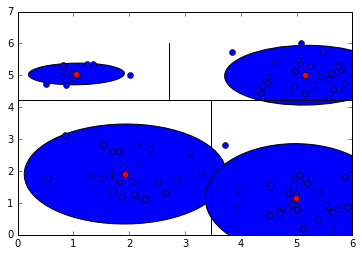

In [22]:
from matplotlib.patches import Ellipse

def plotsplits(h,s,hor=[0,6],vert=[0,6]):
   
        plotsplits(h,s+1,hor,vert) 

fig = plt.figure(0)
ax = fig.add_subplot(111)

nodes=DensityTree.leaf_nodes()
tree=DensityTree.tree
plt.plot(data[:,0],data[:,1], "o")
for d in nodes:
    print(tree[d].split)
    print(tree[d].history)
    vert=[0,6]
    hor=[0,6]
    for h in tree[d].history:
        #plotsplits(h,0)
        if h['direction']==0:
            ax.plot([h['split'],h['split']],vert,color='k')
            if(h['child']=='left'):
                hor=[hor[0],h['split']]
            else:
                hor=[h['split'],hor[1]]
        else:
            ax.plot(hor,[h['split'],h['split']],color='k')
            if(h['child']=='left'):
                vert=[vert[0],h['split']]
            else:
                vert=[h['split'],vert[1]]
    vec1=np.array([0,1])
    print(('tree covariance: ',tree[d].cov))
    #ax.plot([tree[d].mean[0],(tree[d].cov[:,0]-tree[d].mean)[0]],[tree[d].mean[1],(tree[d].cov[:,1]-tree[d].mean)[1]])
    ax.add_artist(Ellipse(xy=tree[d].mean, width=np.linalg.norm(tree[d].cov[:,0]*10), height=np.linalg.norm(tree[d].cov[:,1]*10), angle=np.arccos(np.dot(vec1,tree[d].cov[:,0]*10)/(np.linalg.norm(vec1)*np.linalg.norm(tree[d].cov[:,0]*10)))))
   # if(len(h)<s):
    #print(tree[d].root)
    plt.plot(tree[d].mean[0],tree[d].mean[1],'o',color='r')
    plt.savefig('example.png')
 #   lines=d.history
  #  if lines['direction']==0:
   #     plot
   # plt.savefig('results')

In [181]:
data2 = np.zeros([100,2])
for i in range(100):
    data2[i]=np.random.normal([2,2],1)
    
print(np.linalg.det(np.cov(np.transpose(data2))))

0.986957740915


In [19]:
print(np.log(-1))

nan


c:\program files\python35\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
